In [346]:
from sklearn import cluster, datasets, mixture
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal


In [347]:
noisy_moons = datasets.make_moons(n_samples=500, noise=.11)



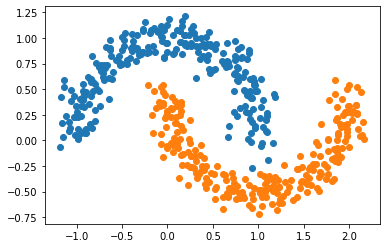

In [348]:
c_0 = noisy_moons[0][ np.where(noisy_moons[1] == 0)]
c_1 = noisy_moons[0][np.where(noisy_moons[1] == 1)]


plt.scatter(c_0[:, 0], c_0[:, 1])
plt.scatter(c_1[:, 0], c_1[:, 1])



In [349]:
def gause_fit(data):
  # u0 = np.random.normal(loc=0, scale=0.01, size=(2,))
  u0 = data.mean(axis=0)
  sig0 = np.random.normal(loc=0, scale=0.01, size=(2, 2))


  sig = np.cov(data[:, 0], data[:, 1])

  sample_mean = data.mean(axis=0)
  n = data.shape[0]

  un = np.matmul(sig0, np.linalg.inv(sig0 + 1/n * sig)).dot(sample_mean[:, np.newaxis])
  un += 1/n * np.matmul(sig, np.linalg.inv(sig0 + 1/n*sig)).dot(u0[:, np.newaxis])

  sign = 1/n * np.matmul(sig0, np.linalg.inv(sig0 + 1/n*sig))
  sign = np.matmul(sign, sig)

  print(un)
  print(sign)

  return un, sign



In [350]:
un_0, sign_0 = gause_fit(c_0)
un_1, sign_1 = gause_fit(c_1)

sig_0 = np.cov(c_0[:, 0], c_0[:, 1])
sig_1 = np.cov(c_1[:, 0], c_1[:, 1])


[[0.00958888]
 [0.63353563]]
[[4.10267732e-03 5.88979676e-05]
 [6.81285281e-06 4.49222471e-04]]
[[ 0.99756495]
 [-0.14882521]]
[[ 0.00238345 -0.00158327]
 [-0.00013622  0.0004909 ]]


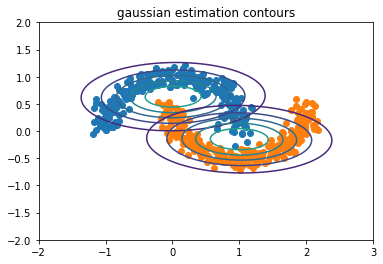

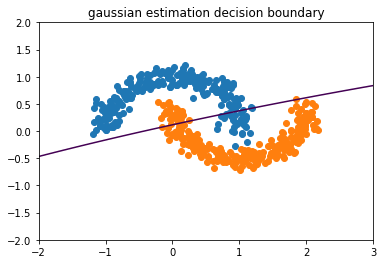

In [351]:
xs, ys = np.linspace(-2, 3, 200), np.linspace(-2, 2, 200)

pln_x, pln_y = np.meshgrid(xs, ys)

pln_x = pln_x.ravel()
pln_y = pln_y.ravel()

pln = np.hstack((pln_x[:, np.newaxis], pln_y[:, np.newaxis]))
z = multivariate_normal.pdf(pln, mean=un_0.squeeze(), cov=sig_0 + sign_0)
z2 = multivariate_normal.pdf(pln, mean=un_1.squeeze(), cov=sig_1 + sign_1)
z3 = multivariate_normal.pdf(pln, mean=un_0.squeeze(), cov=sig_0 + sign_0) -  multivariate_normal.pdf(pln, mean=un_1.squeeze(), cov=sig_1 + sign_1)

z = z.reshape(200, 200)
z2 = z2.reshape(200, 200)
z3 = z3.reshape(200, 200)

pln_x = pln_x.reshape(200, 200)
pln_y = pln_y.reshape(200, 200)

fig, ax = plt.subplots()
ax.scatter(c_0[: ,0], c_0[:, 1])
ax.scatter(c_1[: ,0], c_1[:, 1])

ax.contour(pln_x, pln_y, z, levels=np.linspace(0, 1, 10))
ax.contour(pln_x, pln_y, z2, levels=np.linspace(0, 1, 10))
ax.set_title('gaussian estimation contours')

fig2, ax2 = plt.subplots()
ax2.scatter(c_0[: ,0], c_0[:, 1])
ax2.scatter(c_1[: ,0], c_1[:, 1])
ax2.set_title('gaussian estimation decision boundary')

ax2.contour(pln_x, pln_y, z3, levels=[0])



plt.show()




In [352]:
def gmm_fit(data, alphas, us, sigs, k):
  prev_theta = np.concatenate((us.ravel(), sigs.ravel(), alphas.ravel()))

  while(True):
    norms = np.array([multivariate_normal.pdf(data, mean=us[t], cov=sigs[t]) for t in range(k)]).T
    denom = norms[:, np.newaxis, :].dot(alphas[:, np.newaxis]).squeeze()
    nom = np.multiply(np.repeat(alphas[np.newaxis, :], data.shape[0], axis=0), norms)
    p_j = nom / np.repeat(denom[:, np.newaxis], k, axis=1)
    alphas = p_j.mean(axis=0)
    
    denom = np.repeat(p_j.sum(axis = 0)[:, np.newaxis], 2, axis=1)
    temp = np.repeat(p_j[:, :, np.newaxis], 2, axis=2).transpose(1, 0, 2)
    nom = np.multiply(temp, data).sum(axis=1)
    us = np.divide(nom, denom)
    
    
    temp = np.repeat(us[np.newaxis, :, :], data.shape[0], axis=0).transpose(1, 0, 2)
    temp2 = np.repeat(data[np.newaxis, :, :], k, axis=0)

  

    diff = temp2 - temp 
    diff = np.matmul(diff[:, :, :, np.newaxis], diff[:, :, np.newaxis, :])
    temp3 = np.repeat(p_j.T[:, :, np.newaxis], 2, axis=2)
    temp3 = np.repeat(temp3[:, :, :, np.newaxis], 2, axis=3)
    nom = np.multiply(temp3, diff).sum(axis=1)
    temp4 = np.repeat(p_j.sum(axis=0)[:, np.newaxis], 2, axis=1)
    denom = np.repeat(temp4[:, :, np.newaxis], 2, axis=2)
    sigs = nom / denom
    
    
    theta = np.concatenate((us.ravel(), sigs.ravel(), alphas.ravel()))

    # print(np.linalg.norm(theta - prev_theta))
    

    if np.linalg.norm(theta - prev_theta) < 1e-7:
      break 
    
    prev_theta = theta

  return alphas, us, sigs

In [353]:
def p_gmm(x, alphas, us, sigmas, k):
  norms = np.array( [multivariate_normal.pdf(x, us[t], sigmas[t]) for t in range(k)] ).T
  res = np.multiply(np.repeat(alphas[np.newaxis, :], x.shape[0], axis=0), norms).sum(axis=1)
  return res 


In [354]:
def dec_bou(x, alphas, us, sigmas, alphas2, us2, sigmas2,  k):
  norms1 = np.array( [multivariate_normal.pdf(x, us[t], sigmas[t]) for t in range(k)] ).T
  norms2 = np.array( [multivariate_normal.pdf(x, us2[t], sigmas2[t]) for t in range(k)] ).T
  
  res1 = np.multiply(np.repeat(alphas[np.newaxis, :], x.shape[0], axis=0), norms1).sum(axis=1)
  res2 = np.multiply(np.repeat(alphas2[np.newaxis, :], x.shape[0], axis=0), norms2).sum(axis=1)

  return res2 - res1

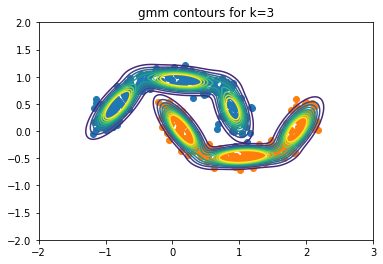

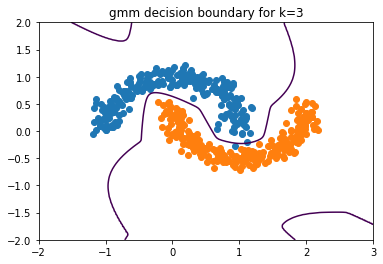

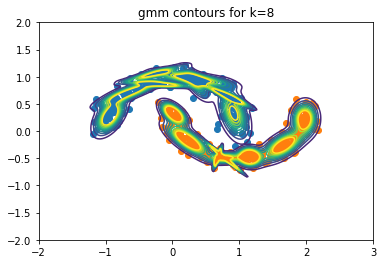

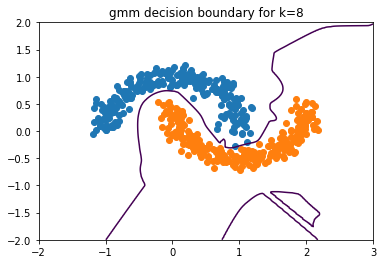

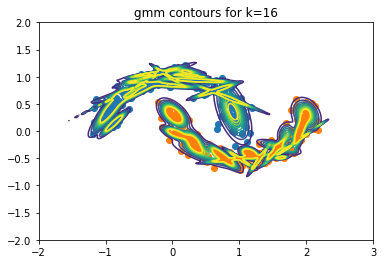

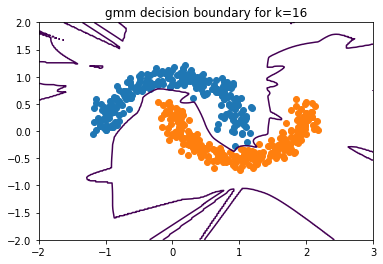

In [355]:
ks = [3, 8, 16]
for k in range(1, 17):
  us_0 = np.random.normal(loc=0, scale=0.01, size=(k, 2))
  us_1 = np.random.normal(loc=0, scale=0.01, size=(k, 2))

  sig_0 = np.array([np.identity(2) for _ in range(k)])
  sig_1 = np.array([np.identity(2) for _ in range(k)])

  alphas_0 = np.ones(k) * (1/k)
  alphas_1 = np.ones(k) * (1/k)

  alphas_0, us_0, sig_0 = gmm_fit(c_0, alphas_0, us_0, sig_0, k)
  alphas_1, us_1, sig_1 = gmm_fit(c_1, alphas_1, us_1, sig_1, k)

  if k in ks:
    xs, ys = np.linspace(-2, 3, 200), np.linspace(-2, 2, 200)

    pln_x, pln_y = np.meshgrid(xs, ys)

    pln_x = pln_x.ravel()
    pln_y = pln_y.ravel()

    pln = np.hstack((pln_x[:, np.newaxis], pln_y[:, np.newaxis]))

    z = p_gmm(pln, alphas_0, us_0, sig_0, k)
    z2 = p_gmm(pln, alphas_1, us_1, sig_1, k)
    z3 = dec_bou(pln, alphas_0, us_0, sig_0, alphas_1, us_1, sig_1, k)

    z = z.reshape(200, 200)
    z2 = z2.reshape(200, 200)
    z3 = z3.reshape(200, 200)


    pln_x = pln_x.reshape(200, 200)
    pln_y = pln_y.reshape(200, 200)

    fig, ax = plt.subplots()
    ax.scatter(c_0[: ,0], c_0[:, 1])
    ax.scatter(c_1[: ,0], c_1[:, 1])

    ax.contour(pln_x, pln_y, z, levels = np.linspace(0, 1, 10))
    ax.contour(pln_x, pln_y, z2, levels = np.linspace(0, 1, 10))
    ax.set_title('gmm contours for k={}'.format(k))
    # ax.contour(pln_x, pln_y, z3, levels = [0])

    fig2, ax2 = plt.subplots()
    ax2.scatter(c_0[: ,0], c_0[:, 1])
    ax2.scatter(c_1[: ,0], c_1[:, 1])

    ax2.contour(pln_x, pln_y, z3, levels=[0])
    ax2.set_title('gmm decision boundary for k={}'.format(k))


  plt.show()